In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

In [3]:
df = pd.read_csv("Delhi house data.csv")

In [5]:
df.head()

,Area,BHK,Bathroom,Furnishing,Locality,Parking,Price,Status,Transaction,Type,Per_Sqft
0,800.0,3,2.0,Semi-Furnished,Rohini Sector 25,1.0,6500000,Ready_to_move,New_Property,Builder_Floor,NaN
1,750.0,2,2.0,Semi-Furnished,"J R Designers Floors, Rohini Sector 24",1.0,5000000,Ready_to_move,New_Property,Apartment,6667.0
2,950.0,2,2.0,Furnished,"Citizen Apartment, Rohini Sector 13",1.0,15500000,Ready_to_move,Resale,Apartment,6667.0
3,600.0,2,2.0,Semi-Furnished,Rohini Sector 24,1.0,4200000,Ready_to_move,Resale,Builder_Floor,6667.0
4,650.0,2,2.0,Semi-Furnished,Rohini Sector 24 carpet area 650 sqft status R...,1.0,6200000,Ready_to_move,New_Property,Builder_Floor,6667.0


In [29]:
df.isna().sum()

Area             0
BHK              0
Bathroom         2
Furnishing       5
Locality         0
Parking         33
Price            0
Status           0
Transaction      0
Type             5
Per_Sqft       241
dtype: int64

In [31]:
df = df.drop('Per_Sqft', axis=1)


In [33]:
df.head()

,Area,BHK,Bathroom,Furnishing,Locality,Parking,Price,Status,Transaction,Type
0,800.0,3,2.0,Semi-Furnished,Rohini Sector 25,1.0,6500000,Ready_to_move,New_Property,Builder_Floor
1,750.0,2,2.0,Semi-Furnished,"J R Designers Floors, Rohini Sector 24",1.0,5000000,Ready_to_move,New_Property,Apartment
2,950.0,2,2.0,Furnished,"Citizen Apartment, Rohini Sector 13",1.0,15500000,Ready_to_move,Resale,Apartment
3,600.0,2,2.0,Semi-Furnished,Rohini Sector 24,1.0,4200000,Ready_to_move,Resale,Builder_Floor
4,650.0,2,2.0,Semi-Furnished,Rohini Sector 24 carpet area 650 sqft status R...,1.0,6200000,Ready_to_move,New_Property,Builder_Floor


In [37]:
bhk_distribution = df['BHK'].value_counts().sort_index()


In [39]:
print(bhk_distribution)

BHK
1      96
2     367
3     541
4     220
5      27
6       6
7       1
10      1
Name: count, dtype: int64


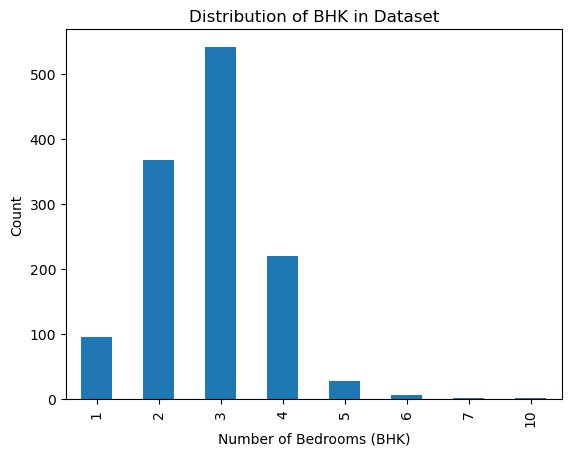

In [43]:
import matplotlib.pyplot as plt
bhk_distribution.plot(kind='bar')

plt.xlabel('Number of Bedrooms (BHK)')
plt.ylabel('Count')
plt.title('Distribution of BHK in Dataset')
plt.show()

## BHK v/s Price

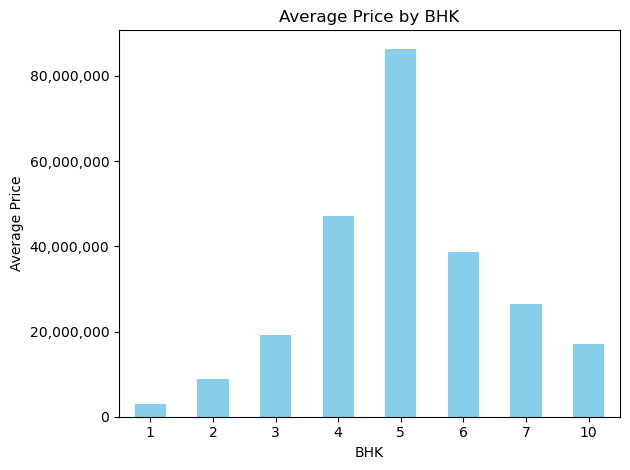

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Load dataset


# Group by 'bhk' and calculate mean price
bhk_price = df.groupby('BHK')['Price'].mean().sort_index()

# Format price labels as currency for display purposes
bhk_price_formatted = bhk_price.apply(lambda x: f"{x:,.0f}")

# Ensure bhk_price is numeric for plotting
bhk_price_numeric = bhk_price.astype(float)

# Plotting the bar chart
fig, ax = plt.subplots()

bhk_price_numeric.plot(kind='bar', color='skyblue', ax=ax)
ax.set_xlabel('BHK')
ax.set_ylabel('Average Price')
ax.set_title('Average Price by BHK')

# Format y-axis labels as currency
formatter = FuncFormatter(lambda x, _: f'{x:,.0f}')
ax.yaxis.set_major_formatter(formatter)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


##  Correlation matrix

In [78]:
df['Bathroom'].fillna(df['Bathroom'].median())
df['Parking'].fillna(df['Parking'].median())
df['Furnishing'].fillna(df['Furnishing'].mode()[0])
df['Type'].fillna(df['Type'].mode()[0])


0       Builder_Floor
1           Apartment
2           Apartment
3       Builder_Floor
4       Builder_Floor
            ...      
1254    Builder_Floor
1255    Builder_Floor
1256    Builder_Floor
1257    Builder_Floor
1258    Builder_Floor
Name: Type, Length: 1259, dtype: object

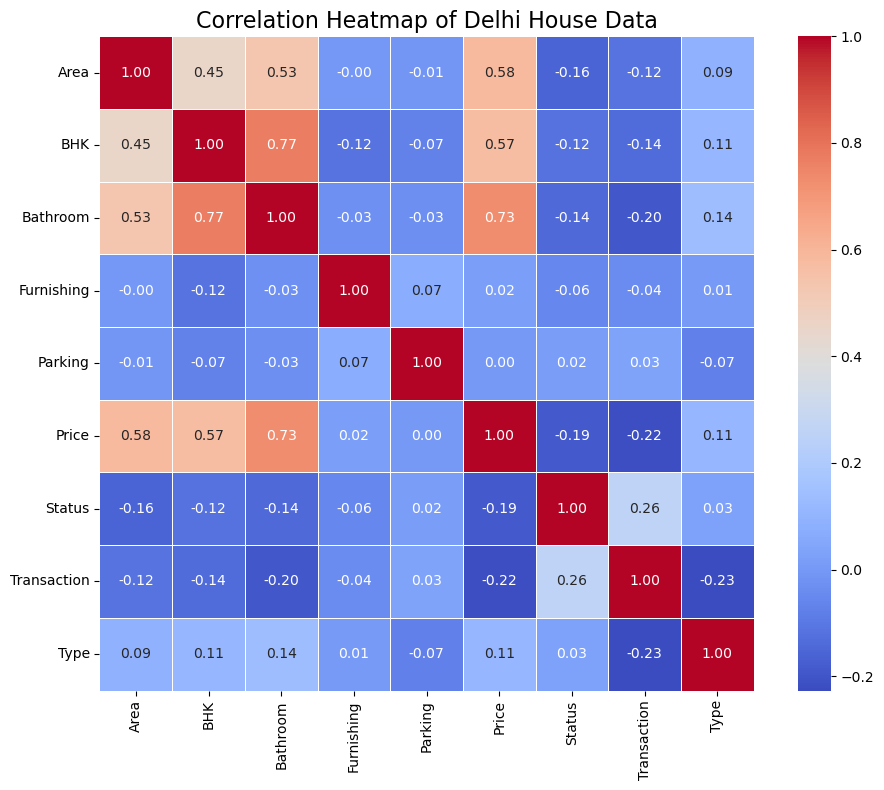

In [82]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
label_cols = ['Furnishing', 'Status', 'Transaction', 'Type']
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])

# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Delhi House Data", fontsize=16)
plt.tight_layout()
plt.show()

In [92]:
# Handle categorical and numerical variables
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove("Price")  # Remove target from numeric features

In [94]:
# Imputation and scaling pipeline
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
])

In [98]:
X = df.drop(columns=["Price"])
y = df["Price"]

# Apply log transformation to target to normalize skewness
y = np.log1p(y)

## Train-test split

In [108]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Apply transformations
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


In [110]:
# Function to compute evaluation metrics
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1-r2) * (len(y_test)-1) / (len(y_test) - X_test.shape[1] - 1)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=5)) * 100
    
    return [round(r2, 3), round(adj_r2, 3), round(mse, 3), round(rmse, 3), round(mae, 3), round(cv_score, 3)]

In [116]:
# Initialize models with improved hyperparameters
models = {
    "Linear Regression": LinearRegression(),
    "Multi-Layer Perceptron": MLPRegressor(hidden_layer_sizes=(100,), max_iter=800, solver='adam', random_state=1),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=12, max_features='sqrt', random_state=42),
    "Support Vector Regression": SVR(kernel='rbf', C=100, gamma=0.1),
    "XGBoost": XGBRegressor(objective='reg:squarederror', n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
}

In [118]:
results = {}
for name, model in tqdm(models.items()):
    metrics = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[name] = metrics

# Create DataFrame with results
columns = ["R Sq.", "Adj. R Sq.", "MSE", "RMSE", "MAE", "C V Score"]
results_df = pd.DataFrame(results, index=columns).T

# Convert target variable back from log scale for interpretation
results_df["MSE"] = np.expm1(results_df["MSE"])
results_df["RMSE"] = np.expm1(results_df["RMSE"])
results_df["MAE"] = np.expm1(results_df["MAE"])

# Display results
print(results_df)


100%|██████████| 5/5 [04:52<00:00, 58.51s/it]

                           R Sq.  Adj. R Sq.        MSE      RMSE       MAE  \
Linear Regression          0.840       1.421   0.202016  0.534186  0.377128   
Multi-Layer Perceptron    -1.968       8.825  29.416949  5.347113  1.971301   
Random Forest              0.780       1.580   0.287883  0.653675  0.496307   
Support Vector Regression  0.847       1.404   0.192438  0.521962  0.344470   
XGBoost                    0.882       1.311   0.145682  0.444842  0.295634   

                           C V Score  
Linear Regression             83.700  
Multi-Layer Perceptron      -187.444  
Random Forest                 82.412  
Support Vector Regression     85.270  
XGBoost                       88.157  


In [120]:
results_df.head()


,R Sq.,Adj. R Sq.,MSE,RMSE,MAE,C V Score
Linear Regression,0.840,1.421,0.202016,0.534186,0.377128,83.700
Multi-Layer Perceptron,-1.968,8.825,29.416949,5.347113,1.971301,-187.444
Random Forest,0.780,1.580,0.287883,0.653675,0.496307,82.412
Support Vector Regression,0.847,1.404,0.192438,0.521962,0.344470,85.270
XGBoost,0.882,1.311,0.145682,0.444842,0.295634,88.157


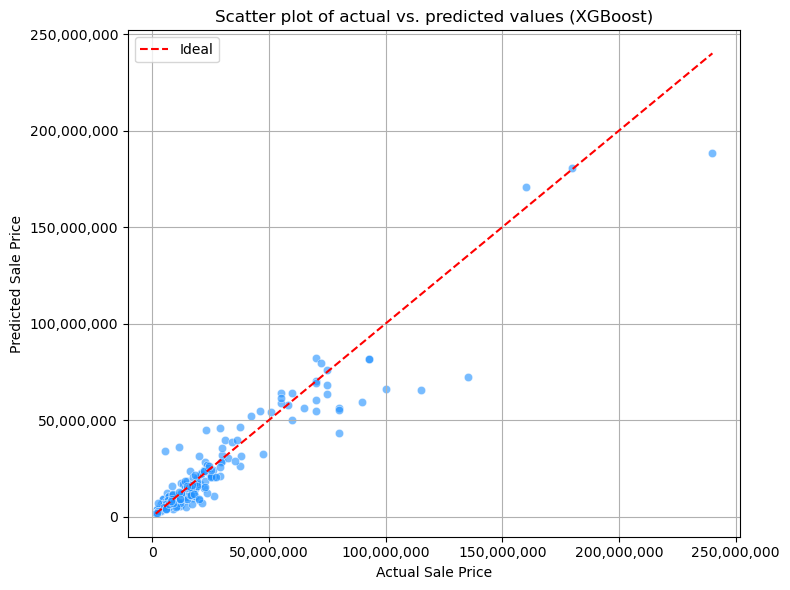

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Train best model again (or use an already trained one)
best_model = models["XGBoost"]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Convert back from log scale
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred)

# Plot Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.6, color='dodgerblue')

# Ideal prediction line
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         '--', color='red', label='Ideal')

plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Scatter plot of actual vs. predicted values (XGBoost)")

# 👉 Format axes to disable scientific notation
ax = plt.gca()

formatter = FuncFormatter(lambda x, _: f'{x:,.0f}')
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [134]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv("Delhi house data.csv")

# Drop rows with missing Per_Sqft
df = df.dropna(subset=['Per_Sqft'])

# Fill missing values
df['Bathroom'].fillna(df['Bathroom'].median())
df['Parking'].fillna(df['Parking'].median())
df['Furnishing'].fillna(df['Furnishing'].mode()[0])
df['Type'].fillna(df['Type'].mode()[0])

# Encode categorical columns
label_cols = ['Furnishing', 'Status', 'Transaction', 'Type']
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])

# Define features and target
X = df.drop(columns=['Price', 'Locality'])  # Drop Price (target) and Locality (text)
y = df['Price']

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance_df)


       Feature  Importance
0         Area    0.693365
2     Bathroom    0.125972
8     Per_Sqft    0.112059
4      Parking    0.022475
1          BHK    0.016742
6  Transaction    0.010894
7         Type    0.007664
3   Furnishing    0.006940
5       Status    0.003889


C:\Users\lenovo\AppData\Local\Temp\ipykernel_31092\3392258195.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


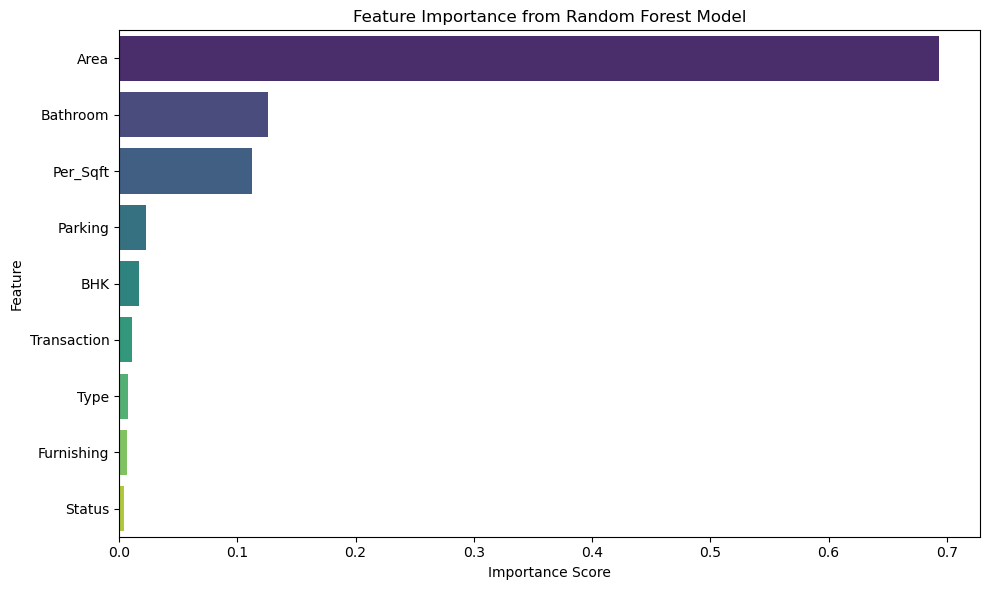

In [136]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance from Random Forest Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [130]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv("Delhi house data.csv")

# Drop rows with missing Per_Sqft
df = df.dropna(subset=['Per_Sqft'])

# Fill missing values
df['Bathroom'].fillna(df['Bathroom'].median())
df['Parking'].fillna(df['Parking'].median())
df['Furnishing'].fillna(df['Furnishing'].mode()[0])
df['Type'].fillna(df['Type'].mode()[0])

# Encode categorical columns
label_cols = ['Furnishing', 'Status', 'Transaction', 'Type']
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])

# Define features and target
X = df.drop(columns=['Price', 'Locality'])  # Drop Price (target) and Locality (text)
y = df['Price']

# Train model
model = XGBRegressor(objective='reg:squarederror', n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X, y)

# Get feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance_df)

       Feature  Importance
0         Area    0.388972
2     Bathroom    0.381692
1          BHK    0.059449
8     Per_Sqft    0.054667
6  Transaction    0.042445
4      Parking    0.023479
7         Type    0.019348
5       Status    0.017425
3   Furnishing    0.012524


C:\Users\lenovo\AppData\Local\Temp\ipykernel_31092\847952300.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


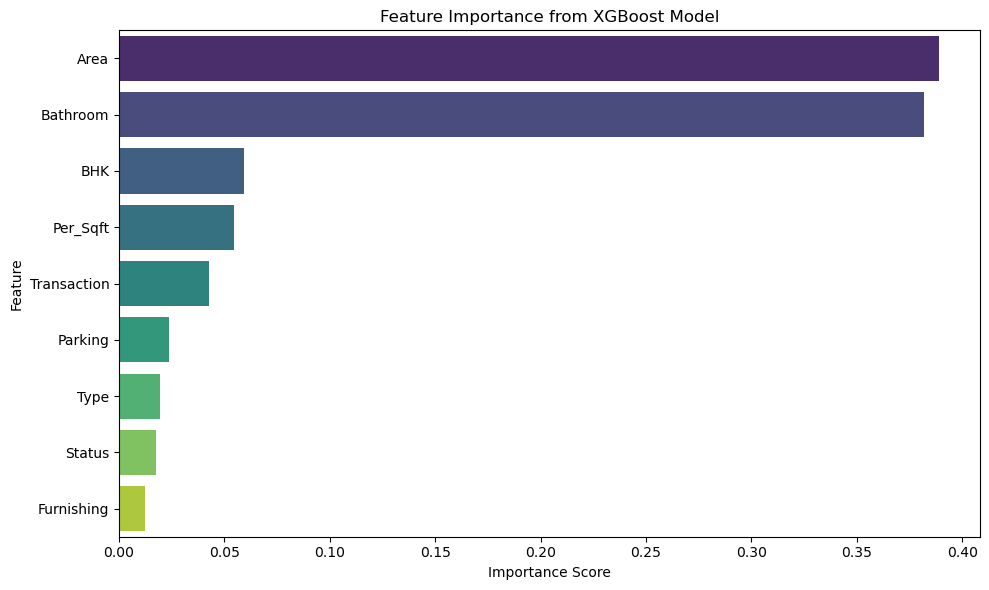

In [132]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance from XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()